# Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

from IPython.display import display
from tqdm.auto import tqdm


# Data Preparation

In [3]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

# Checking the Data

## Target data check

In [5]:
# Check what is the value of the target variable
df.Churn.value_counts()

## Conclusion: Need to change the data type into numeric

No     5174
Yes    1869
Name: Churn, dtype: int64

In [6]:
# Change Churn into 1 (Yes) and 0 (No)
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

## Duplicated check

In [7]:
# Check if there is any duplicated values
df.duplicated().value_counts()

## Conclusion: No duplicated values

False    7043
dtype: int64

## Missing values check

In [8]:
# Check if there is any missing values
df.isnull().sum()

## Conclusion: No missing values

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Data type check

In [9]:
# Checking all the features' data types and its unique values
for dtype, col in list(zip(df.dtypes, df.columns)):
    if dtype == 'int64' or dtype == 'float64':
        print(col, dtype)
        print(df[col].min(), df[col].max())
    else:
        print(col,dtype)
        print(df[col].unique())
    print()

# Conclusion: Need to change SeniorCitizen to become object data type and TotalCharges to numeric

customerID object
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender object
['Female' 'Male']

SeniorCitizen int64
0 1

Partner object
['Yes' 'No']

Dependents object
['No' 'Yes']

tenure int64
0 72

PhoneService object
['No' 'Yes']

MultipleLines object
['No phone service' 'No' 'Yes']

InternetService object
['DSL' 'Fiber optic' 'No']

OnlineSecurity object
['No' 'Yes' 'No internet service']

OnlineBackup object
['Yes' 'No' 'No internet service']

DeviceProtection object
['No' 'Yes' 'No internet service']

TechSupport object
['No' 'Yes' 'No internet service']

StreamingTV object
['No' 'Yes' 'No internet service']

StreamingMovies object
['No' 'Yes' 'No internet service']

Contract object
['Month-to-month' 'One year' 'Two year']

PaperlessBilling object
['Yes' 'No']

PaymentMethod object
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

MonthlyCharges float64
18.25 118.75

TotalCharges object
['29.85' '

In [10]:
# Change data type from int64 to object
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

### Missing values check

In [11]:
# Check if there is any missing values after change the data types
df.isnull().sum()

## Conclusion: Need to fill TotalCharges, will be filled after the data splpit

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

# Data split
Data splitting proportion: data_train (60%), data_val (20%), data_test (20%).

Split the full data into df_full_train and df_test, then split again the df_full_train into df_train and df_val.

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train['Churn']
y_val = df_val['Churn']
y_test = df_test['Churn']

del df_train['Churn']
del df_val['Churn']
del df_test['Churn']

# Data Processing for EDA

In [15]:
df_train.TotalCharges.fillna(df_train.TotalCharges.median(), inplace=True)
df_val.TotalCharges.fillna(df_val.TotalCharges.median(), inplace=True)
df_test.TotalCharges.fillna(df_test.TotalCharges.median(), inplace=True)

df_full_train.TotalCharges.fillna(df_full_train.TotalCharges.median(), inplace=True)

# EDA

## Insights
Doing exploratory data analysis to see some insights.

### Numeric Features

In [16]:
# Extract only numeric features
num_feat = list(df.select_dtypes(include=['int64', 'float64']).columns)

num_feat

['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

#### Target features

In [17]:
# Percentage for each positive and negative classes
df.Churn.value_counts(normalize=True)

## Conclusion: The dataset isn't too imbalance

0    0.73463
1    0.26537
Name: Churn, dtype: float64

#### Distributions
See how the distributions look like for each numeric features.

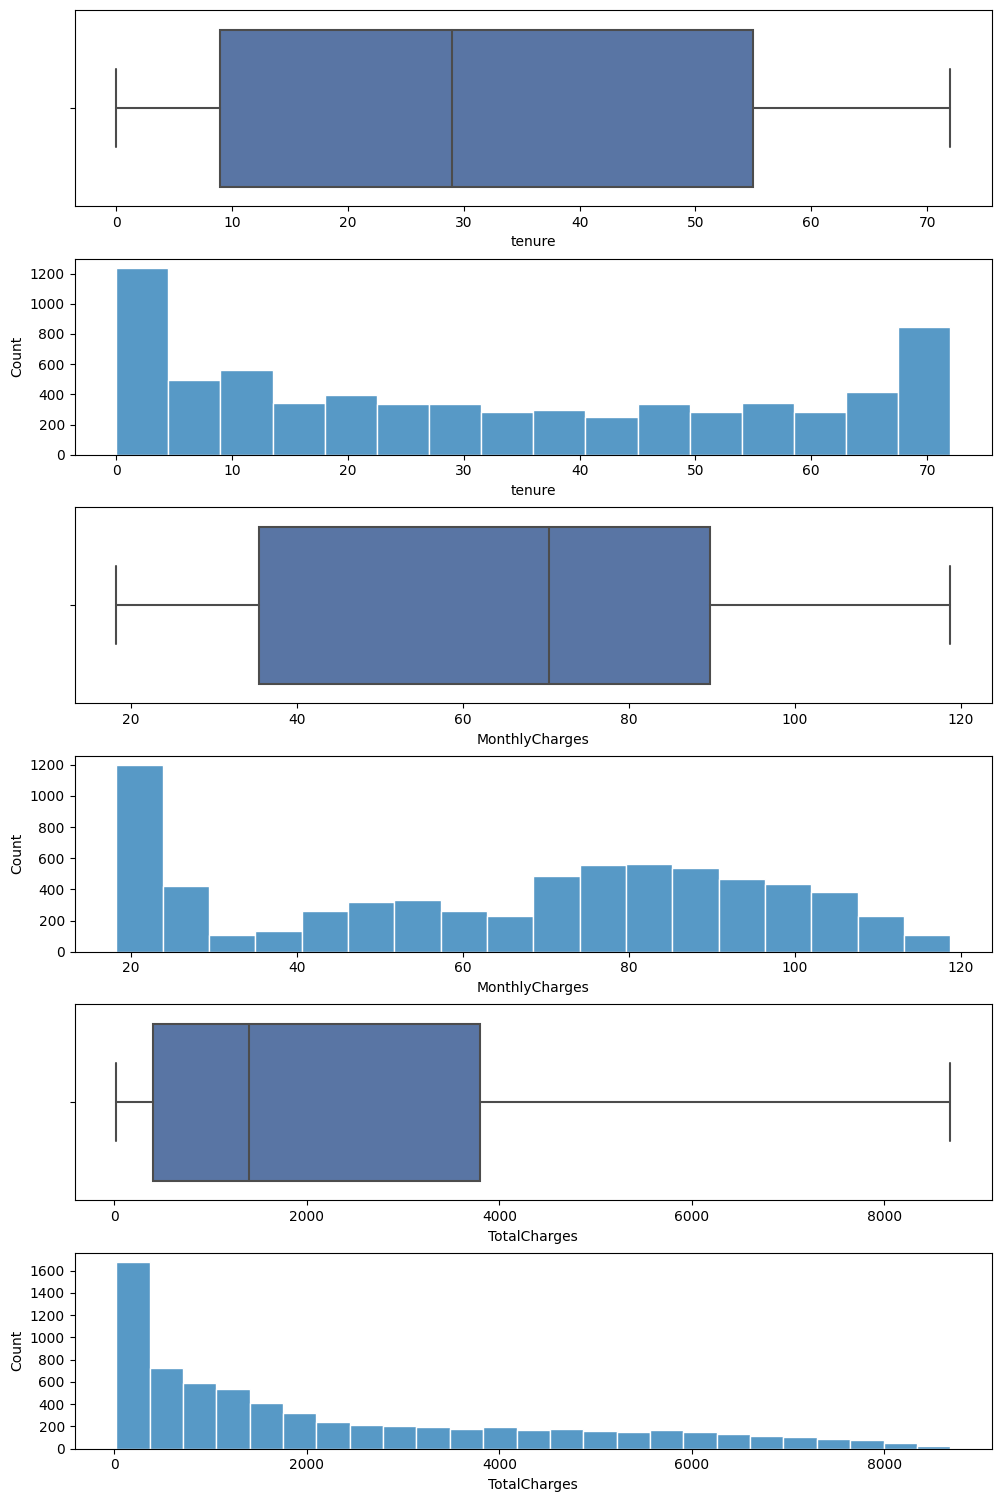

In [18]:
fig, ax = plt.subplots(6, figsize=(10, 15))
sns.set(font_scale=.5)

g=sns.boxplot(data=df, x="tenure", ax=ax[0])
g=sns.histplot(data=df, x="tenure", ax=ax[1])


g=sns.boxplot(data=df, x="MonthlyCharges", ax=ax[2])
g=sns.histplot(data=df, x="MonthlyCharges", ax=ax[3])


g=sns.boxplot(data=df, x="TotalCharges", ax=ax[4])
g=sns.histplot(data=df, x="TotalCharges", ax=ax[5])

plt.tight_layout()

- We see we have many customers who stay less than 10 months in the company. However, there is a small spike in customers who are loyal enough to stay up to 72 months.

- The monthly charges have a right skewed distribution, there are lots of small charges from 20 to 25 which means a huge proportion of customers have around  20− 25 monthly charges and less customers have more than 25 dollars.

- The same pattern appears in TotalCharges. There is a huge majority of TotalCharges range between 0 to 2000 dollars and a smaller amounts of monthly charges above 2000 dollars.

- Finally all the numerical features have a right skewed distribution.

### Categoric Features

In [19]:
cat_feat = list(df_full_train.select_dtypes(include=['object']).columns)
cat_feat.remove('customerID')
cat_feat

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

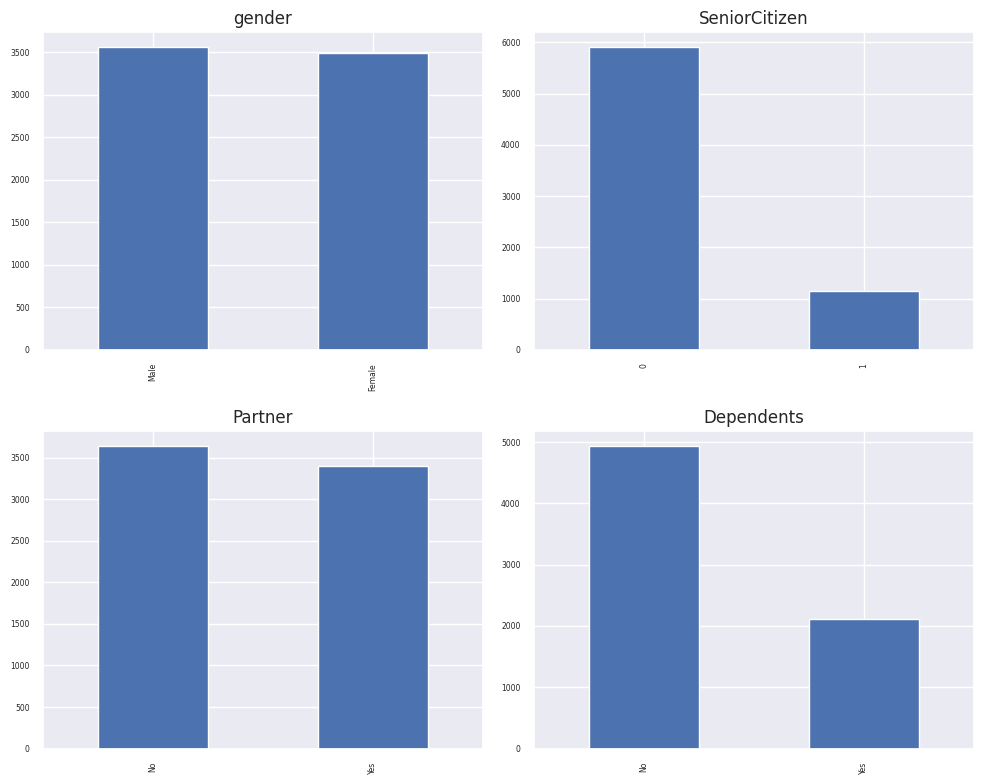

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.set(font_scale=1)

for elem, ax in zip(cat_feat[:4], axs.ravel()):
    
    df[elem].value_counts().plot(kind='bar', ax=ax, title=elem)

fig.tight_layout()

- Genders, seems we have equal number of both males and females, and both show equal amount of churned customers.

- We have young customers compared to senior.

- Customers with or without partners are about the same.

- Seems we have more customers without dependent members than those who have.

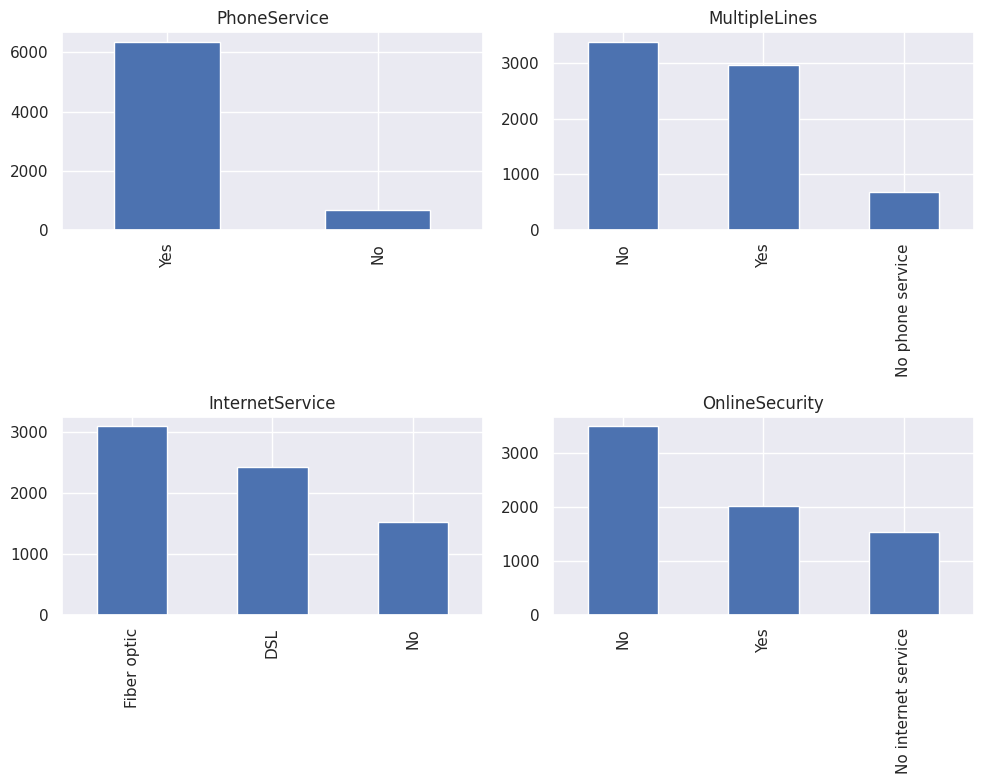

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.set(font_scale=1)

for elem, ax in zip(cat_feat[4:8], axs.ravel()):
    
    df[elem].value_counts().plot(kind='bar', ax=ax, title=elem)

fig.tight_layout()

- Our customers mostly have a phone service.

- Customers who have internet service, prefer mostly DSL or Fiber optic.
- There is a common pattern in the features MultipleLines & OnlineSecurity. It is illustated that most of the customers prefer not to have access to these features than those who have.

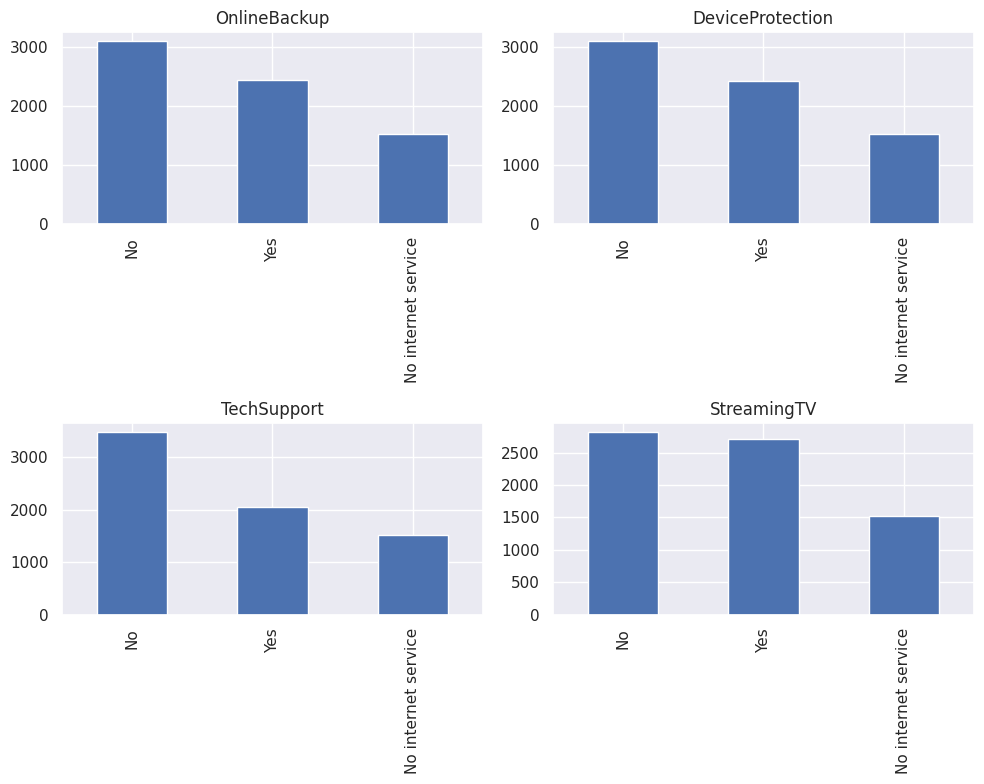

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.set(font_scale=1)

for elem, ax in zip(cat_feat[8:12], axs.ravel()):
    
    df[elem].value_counts().plot(kind='bar', ax=ax, title=elem)

fig.tight_layout()

- There is a common pattern in the features OnlineBackup & TechSupport. It is illustated that most of the customers prefer not to have access to these features than those who have.
- The features, StreamingMovies and StreamingTV has similar barplots, which means there is an equal amount of customers who prefer to either prefer these services or not to.

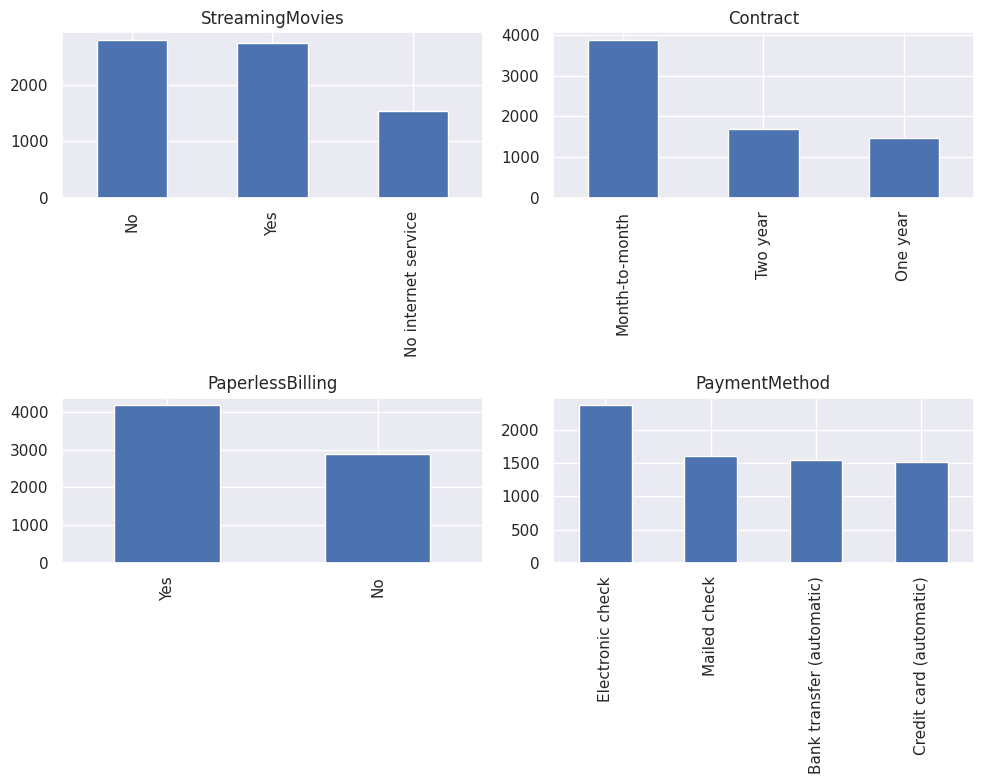

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.set(font_scale=1)

for elem, ax in zip(cat_feat[12:16], axs.ravel()):
    
    df[elem].value_counts().plot(kind='bar', ax=ax, title=elem)

fig.tight_layout()

- The features, StreamingMovies and StreamingTV has similar barplots, which means there is an equal amount of customers who prefer to either prefer these services or not to.
- In general customers prefer month-to-month contracts wcompared to other types such as two year or one year contracts.
- Finally, most customers would rather have Paperless billing than any other form and seems they use all the different forms of banking transactions such with Electronic Check being the majority.

## For Modelling

### Numeric Features

In [24]:
num_feat

['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

In [25]:
num_feat.remove('Churn')

#### Correlation

In [26]:
df_train[num_feat].corrwith(y_train)

tenure           -0.355962
MonthlyCharges    0.189665
TotalCharges     -0.200181
dtype: float64

- The longer the customer stays with the company (tenure), the less likely the customer will churn.
- The more people pay (MonthlyCharges), most likely they will churn.
- For TotalCharges is the other way, the more people pay, the less likely they will churn, this is counterintuitive.

#### ANOVA Testing

In [27]:
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(df_train[num_feat], y_train)

# Convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': df_train[num_feat].columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table


## Conclusion: All the features has so close to zero p-values and has high scores of F-Score which means all the features has impact on response variable

,Numerical_Feature,F-Score,p values
0,tenure,612.728570,0.0
1,TotalCharges,176.290579,0.0
2,MonthlyCharges,157.582191,0.0


### Categorical Features

In [28]:
cat_feat

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

#### Mutual Information Score

In [29]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, y_train)

In [30]:
mi = df_train[cat_feat].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

## Conclusion: SeniorCitizen, Partner, MultipleLines, gender, PhoneService aren't that supportive, the model will learn nothing about the churn

Contract            0.099016
OnlineSecurity      0.061654
TechSupport         0.057836
InternetService     0.052373
OnlineBackup        0.042997
DeviceProtection    0.041384
PaymentMethod       0.035928
StreamingTV         0.030897
StreamingMovies     0.030317
PaperlessBilling    0.016911
Dependents          0.012709
SeniorCitizen       0.008996
Partner             0.008903
MultipleLines       0.000841
gender              0.000162
PhoneService        0.000044
dtype: float64

#### Chi-square Testing
Test the hypothesis whether these categoric features has really the impact for predicting the churn.

In [31]:
# Define an empty dictionary to store chi-squared test results
chi2_check = {}

# Loop over each column in the training set to calculate chi-statistic with the target variable
for column in df_train[cat_feat]:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, df_train[cat_feat][column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# Convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result


## Conclusion: Only gender & PhoneService that has no impact on Churn statistically.

,Feature,p-value
0,SeniorCitizen,0.000000
1,Partner,0.000000
2,Dependents,0.000000
3,InternetService,0.000000
4,OnlineSecurity,0.000000
5,OnlineBackup,0.000000
6,DeviceProtection,0.000000
7,TechSupport,0.000000
8,StreamingTV,0.000000
9,StreamingMovies,0.000000


# Feature Selection

In [32]:
# Remove these not significant features
cat_feat.remove('gender')
cat_feat.remove('PhoneService')

In [33]:
# Features that will be used for modelling
final_feat = num_feat + cat_feat
final_feat

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

# Data Processing for Modelling

In [34]:
dicts_train = df_train[final_feat].to_dict(orient='records')
dicts_val = df_val[final_feat].to_dict(orient='records')

In [35]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)
X_val = dv.transform(dicts_val)

# Modelling

## Choosing BaseModel

In [36]:
model = LogisticRegression(solver="liblinear", C=1.0, 
                           max_iter=1000, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]

print('LogisticRegression ROCAUC result:', roc_auc_score(y_val,  y_pred).round(3))

LogisticRegression ROCAUC result: 0.846


In [37]:
model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]

print('RandomForest ROCAUC result:', roc_auc_score(y_val,  y_pred).round(3))

RandomForest ROCAUC result: 0.824


In [38]:
## Conclusion will select LogisticRegression as a BaseModel, because it is much simpler and has higher ROCAUC score

## Tuning

In [39]:
def train(df,y_train, C=1):
    dicts = df[final_feat].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [40]:
def predict(df,dv, model):
    dicts = df[final_feat].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [41]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in tqdm([0.01, 0.1, 1, 10]):
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.Churn.values
        y_val = df_val.Churn.values

        dv, model = train(df_train, y_train,C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print("C:", C,"score:", np.mean(scores).round(3), "+-", np.std(scores).round(3))

# Conclusion: The best value for C is 0.1

  0%|          | 0/4 [00:00<?, ?it/s]

C: 0.01 score: 0.839 +- 0.009
C: 0.1 score: 0.841 +- 0.008
C: 1 score: 0.841 +- 0.008
C: 10 score: 0.841 +- 0.008


# Performance stability check 

In [42]:
dicts_full_train = df_full_train[final_feat].to_dict(orient='records')
dicts_test = df_test[final_feat].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)
X_test = dv.transform(dicts_test)

In [43]:
model = LogisticRegression(solver="liblinear", C=0.1, 
                           max_iter=1000, random_state=42)

model.fit(X_full_train, df_full_train.Churn)

y_pred = model.predict_proba(X_test)[:,1]

print('LogisticRegression ROCAUC result:', roc_auc_score(y_test,  y_pred).round(3))

LogisticRegression ROCAUC result: 0.858


The score between validation and test set isn't that big.